In [2]:
import numpy as np
import pandas as pd
import sqlite3
import math
from scipy import stats

import matplotlib.pyplot as plt
from warnings import warn
from scipy import interp
import seaborn as sns
# import squarify

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

/usr/local/lib64/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Loading data

In [3]:
# Read sqlite query results into a pandas DataFrame
# con = sqlite3.connect("C:/Users/kasina/Dropbox/Python tutorial/Loan data set/database.sqlite")
con = sqlite3.connect("/mnt/lynx/python_tutorial/database.sqlite")
df = pd.read_sql_query("SELECT * from loan", con)

# verify that result of SQL query is stored in the dataframe
print(df.head())
con.close()

   index       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      0  1077501  1296599.0     5000.0       5000.0           4975.0   
1      1  1077430  1314167.0     2500.0       2500.0           2500.0   
2      2  1077175  1313524.0     2400.0       2400.0           2400.0   
3      3  1076863  1277178.0    10000.0      10000.0          10000.0   
4      4  1075358  1311748.0     3000.0       3000.0           3000.0   

         term int_rate  installment grade     ...      total_bal_il il_util  \
0   36 months   10.65%       162.87     B     ...               NaN     NaN   
1   60 months   15.27%        59.83     C     ...               NaN     NaN   
2   36 months   15.96%        84.33     C     ...               NaN     NaN   
3   36 months   13.49%       339.31     C     ...               NaN     NaN   
4   60 months   12.69%        67.79     B     ...               NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         Na

In [4]:
print(df.shape)
df.head(2)

(887383, 75)


index       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      0  1077501  1296599.0     5000.0       5000.0           4975.0   
1      1  1077430  1314167.0     2500.0       2500.0           2500.0   

         term int_rate  installment grade     ...      total_bal_il il_util  \
0   36 months   10.65%       162.87     B     ...               NaN     NaN   
1   60 months   15.27%        59.83     C     ...               NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN         NaN         NaN      NaN              NaN    NaN   
1         NaN         NaN         NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  

[2 rows x 75 columns]

In [5]:
print('Data types in loan table:')
df.columns.to_series().groupby(df.dtypes).count()

Data types in loan table:


int64       1
float64    48
object     26
dtype: int64

# 2. Exploring Variables

## 2.1 Target variable

In [6]:
# target variable
df.groupby(df['loan_status']).size()

loan_status
Charged Off                                             45248
Current                                                601781
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Does not meet the credit policy. Status:Fully Paid       1988
Fully Paid                                             207724
In Grace Period                                          6253
Issued                                                   8460
Late (16-30 days)                                        2357
Late (31-120 days)                                      11591
dtype: int64

In [7]:
# take only rows with target variables that can be used in modeling
data = df.loc[df['loan_status'].isin(['Charged Off','Default','Fully Paid'])]
               
data.groupby(data['loan_status']).size()

loan_status
Charged Off     45248
Default          1219
Fully Paid     207724
dtype: int64

In [8]:
# Convert the target variable to an integer value
valmap = {'Charged Off': 1, 'Default': 1, 'Fully Paid': 0}
data['loan_status'] = data['loan_status'].apply(lambda x: valmap[x])
# for n in valmap.keys():
#     data.loc[data.loan_status == n, 'loan_status'] = valmap[n]

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Percentage of bad loans
100 * data.loan_status.sum()/data.shape[0]

18.28034824206994

## 2.2 Numerical variables

In [9]:
# list of numerical variables
num_var_list = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64']]

In [115]:
def variExplorer(list_of_explore,ds_num,target_var):
    
    labels = data.loan_status
    
    fig, axes = plt.subplots(len(list_of_explore),2,figsize = (12,len(list_of_explore)*3))
    plt.style.use('seaborn-ticks')
    
    boxplot_base_sep = list()
    mean_list = []
    std_list = []
    perc_02_list = []
    perc_98_list = []
    
    for var in list_of_explore:
        boxplot_base = ds_num.loc[:,[var,target_var]]
        boxplot_base_sep.append([boxplot_base[boxplot_base[target_var]==1][var].dropna(),boxplot_base[boxplot_base[target_var]==0][var].dropna()])
        
        mean_list.append(ds_num[var].dropna().mean())
        std_list.append(ds_num[var].dropna().std())
        perc_02_list.append(np.percentile(np.array(ds_num[var].dropna()), 2))
        perc_98_list.append(np.percentile(np.array(ds_num[var].dropna()), 98))
        
    for i in range(len(list_of_explore)):
        axes[i,0].boxplot(boxplot_base_sep[i],vert=True)
        axes[i,0].set_ylim(perc_02_list[i] - std_list[i], perc_98_list[i] + std_list[i])
        axes[i,0].set_title('Variable: {}'.format(list_of_explore[i]))
        axes[i,0].set_xticklabels(labels)
        axes[i,1].hist(boxplot_base_sep[i],
                       bins = 50,
                       normed = True,
                       histtype="stepfilled",
#                        range=(perc_02_list[i] - std_list[i], perc_98_list[i] + std_list[i]),
                       range=(perc_02_list[i], perc_98_list[i]),
                       alpha= 0.6,
                       label=labels
                      )
        axes[i,1].legend()
    fig.tight_layout()
    plt.show()

C:\Users\kasina\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\kasina\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6198: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


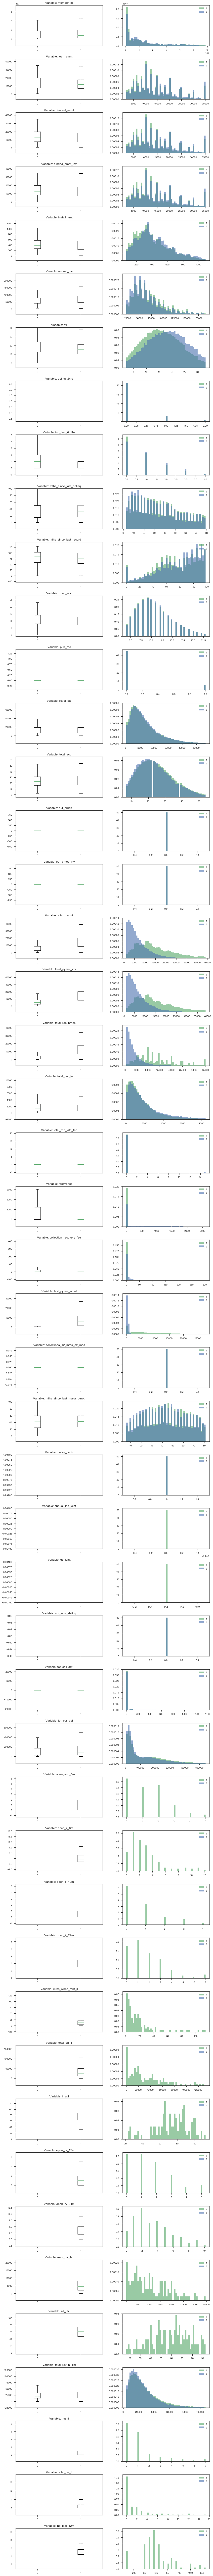

In [116]:
# without standard deviation
variExplorer(num_var_list,data,'loan_status')

In [135]:
def variExplorer(list_of_explore,ds_num,target_var):
    
    labels = data.loan_status
    
    fig, axes = plt.subplots(len(list_of_explore),2,figsize = (12,len(list_of_explore)*3))
    plt.style.use('seaborn-ticks')
    
    boxplot_base_sep = list()
    mean_list = []
    std_list = []
    perc_02_list = []
    perc_98_list = []
    
    for var in list_of_explore:
        boxplot_base = ds_num.loc[:,[var,target_var]]
        boxplot_base_sep.append([boxplot_base[boxplot_base[target_var]==1][var].dropna(),boxplot_base[boxplot_base[target_var]==0][var].dropna()])
        
        mean_list.append(ds_num[var].dropna().mean())
        std_list.append(ds_num[var].dropna().std())
        perc_02_list.append(np.percentile(np.array(ds_num[var].dropna()), 2))
        perc_98_list.append(np.percentile(np.array(ds_num[var].dropna()), 98))
    
    std_list = [0 if math.isnan(v) else v for v in std_list]
    
    for i in range(len(list_of_explore)):
        axes[i,0].boxplot(boxplot_base_sep[i],vert=True)
        axes[i,0].set_ylim(perc_02_list[i] - std_list[i], perc_98_list[i] + std_list[i])
        axes[i,0].set_title('Variable: {}'.format(list_of_explore[i]))
        axes[i,0].set_xticklabels(labels)
        axes[i,1].hist(boxplot_base_sep[i],
                       bins = 50,
                       normed = True,
                       histtype="stepfilled",
                       range=(perc_02_list[i] - std_list[i], perc_98_list[i] + std_list[i]),
#                        range=(perc_02_list[i], perc_98_list[i]),
                       alpha= 0.6,
                       label=labels
                      )
        axes[i,1].legend()
    fig.tight_layout()
    plt.show()

C:\Users\kasina\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\kasina\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=36000.0, top=36000.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\kasina\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6198: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()
C:\Users\kasina\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=17.6, top=17.6
  'bottom=%s, top=%s') % (bottom, top))


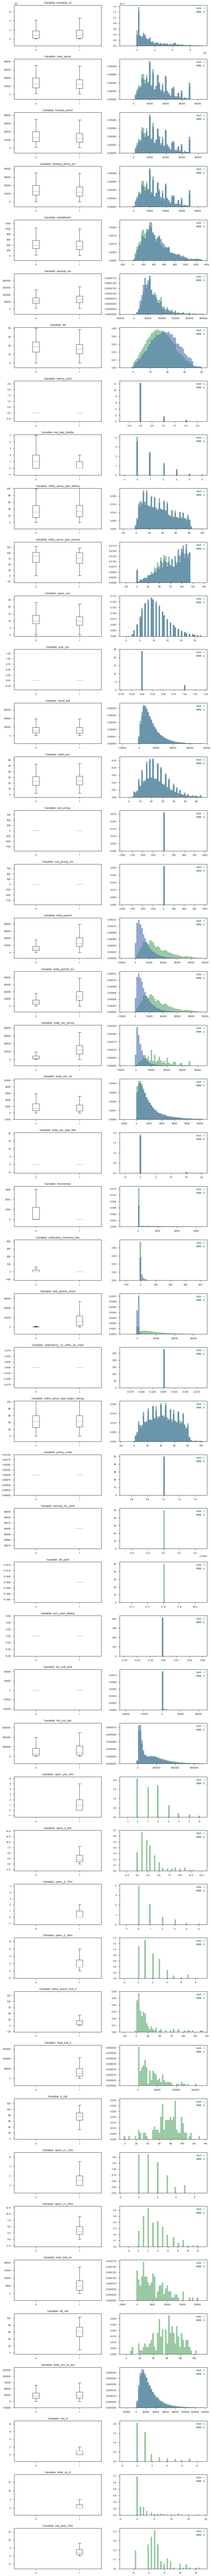

In [137]:
# with standard deviation
variExplorer(num_var_list,data,'loan_status')

## 2.3 Categorical variables

In [11]:
# list of categorical variables
[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object']]

['id',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint']

In [16]:
cat_var_list1 = ['term',
#  'int_rate',
 'grade',
 'sub_grade',
#  'emp_title',
#  'emp_length',
 'home_ownership',
 'verification_status',
#  'issue_d',
 'pymnt_plan',
#  'url',
#  'desc',
 'purpose',
#  'title',
#  'zip_code',
#  'addr_state',
#  'earliest_cr_line',
#  'revol_util',
 'initial_list_status',
#  'last_pymnt_d',
#  'next_pymnt_d',
#  'last_credit_pull_d',
 'application_type',
 'verification_status_joint']

In [17]:
def categorical_explorer(list_of_explore,ds_num,target_var):
    
    sns.set(style="whitegrid", color_codes=True)
    
    for var in list_of_explore:
        boxplot_base = ds_num[[var,target_var]]
        ax = sns.barplot(y=var, x=target_var, data=boxplot_base, color = 'g')
        plt.show()

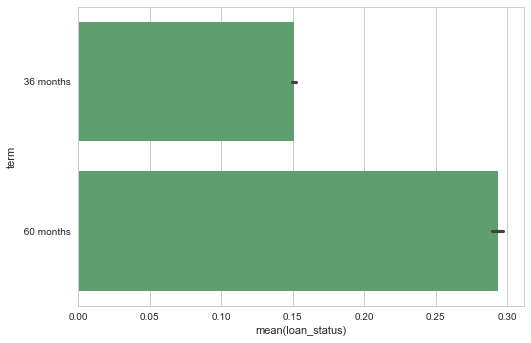

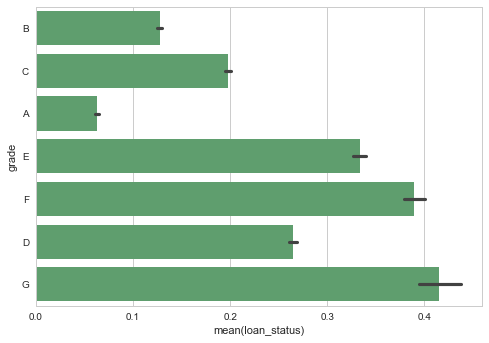

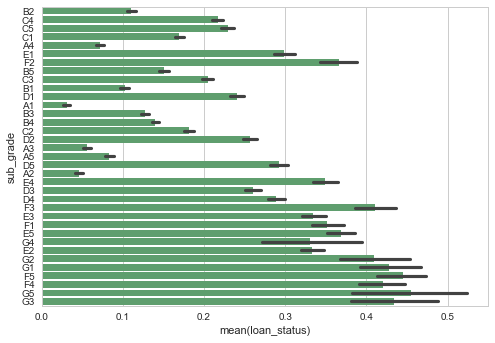

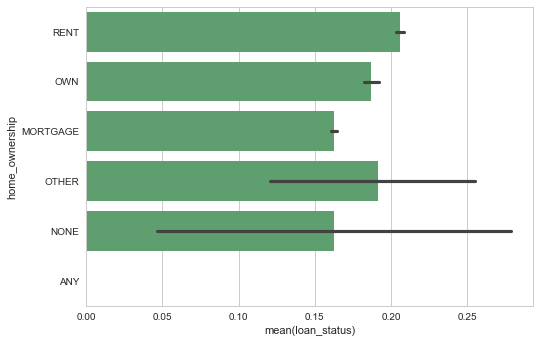

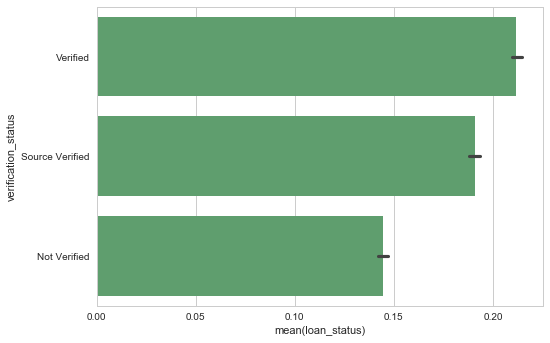

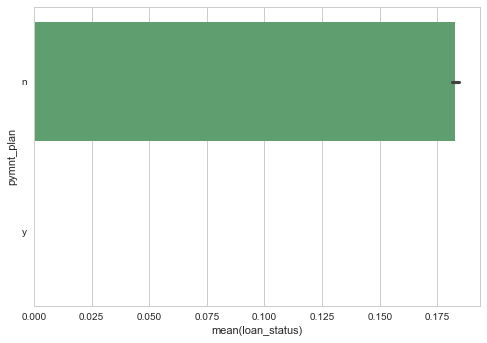

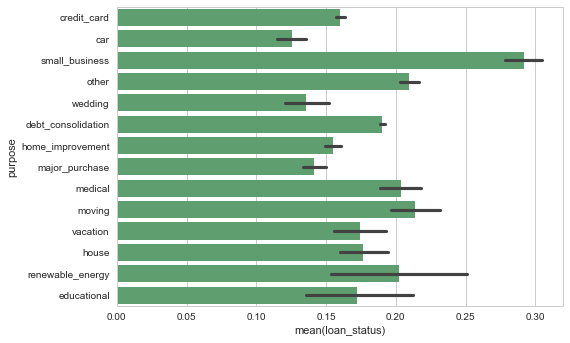

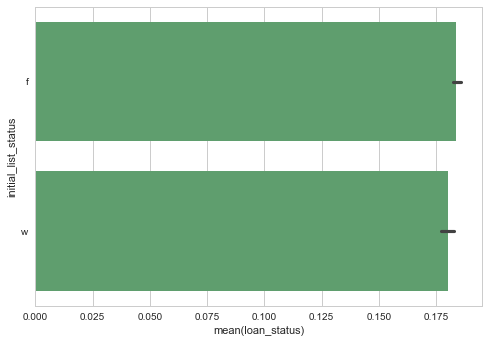

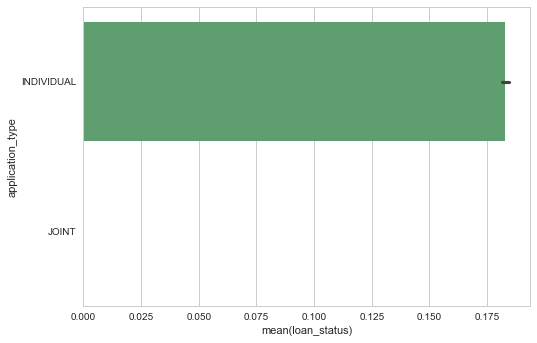

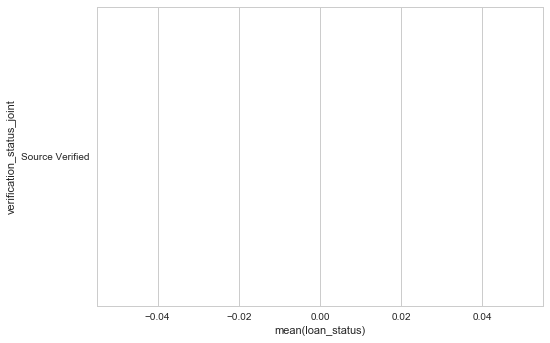

In [18]:
categorical_explorer(cat_var_list1,data,'loan_status')

In [23]:
cat_var_list2 = [
 'int_rate',
#  'emp_title',
 'emp_length',
 'issue_d',
#  'url',
#  'desc',
#  'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',]

int_rate


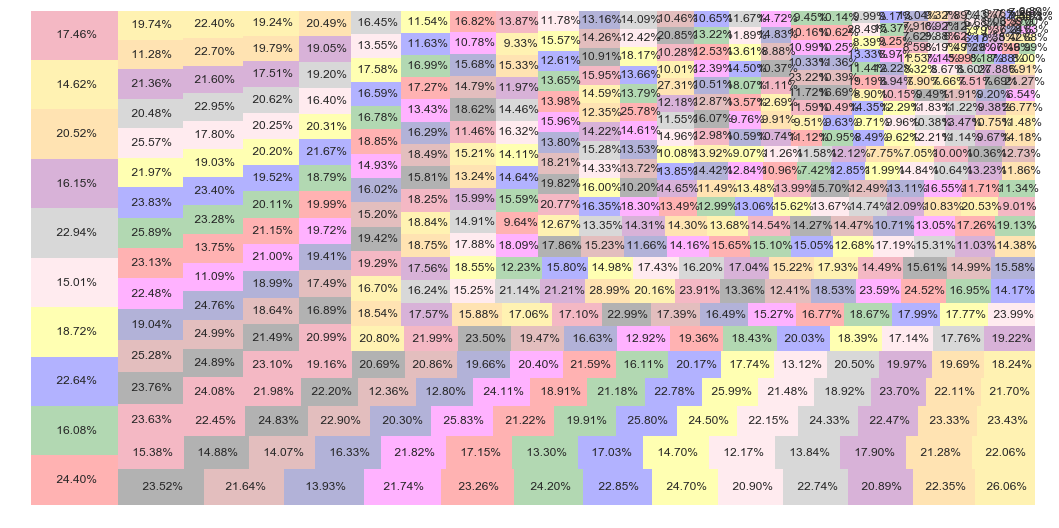

emp_length


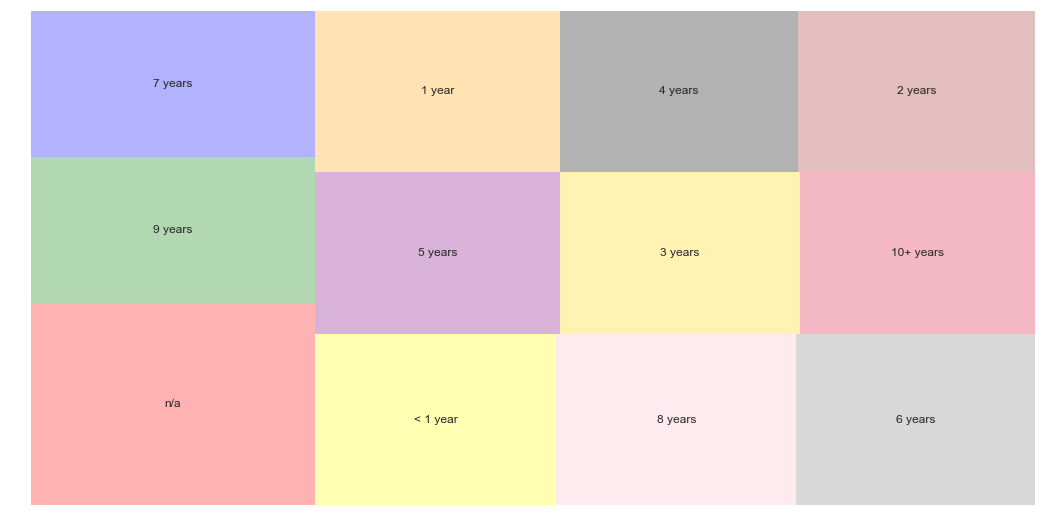

issue_d


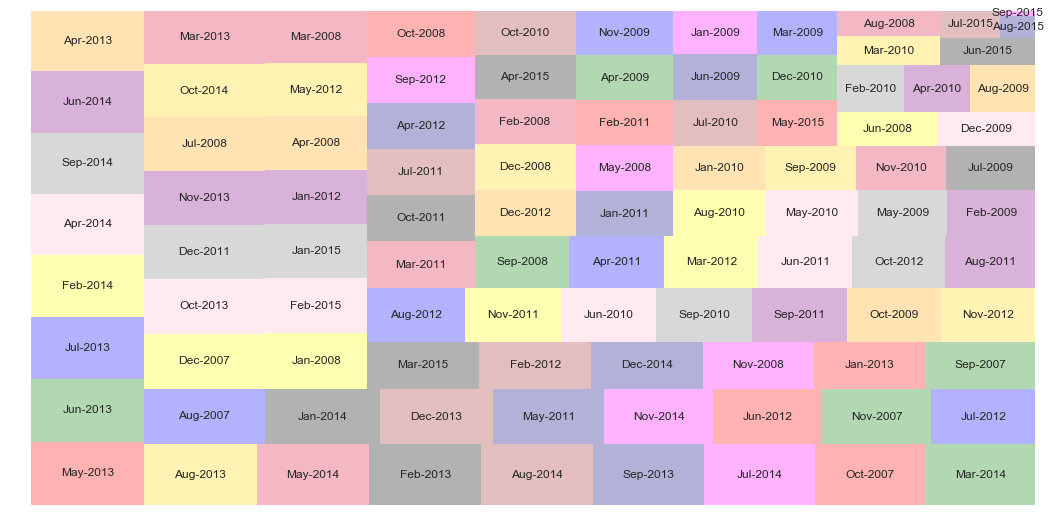

zip_code


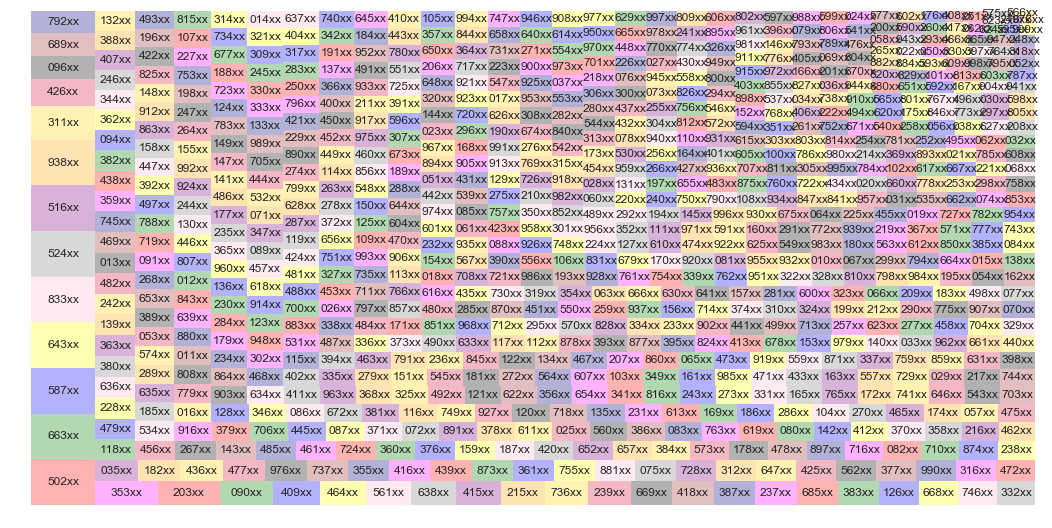

addr_state


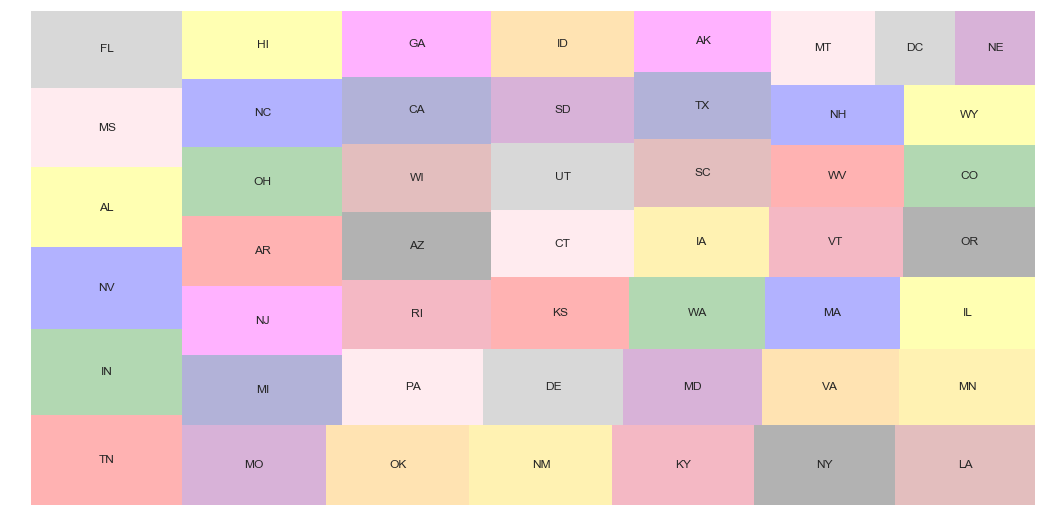

earliest_cr_line


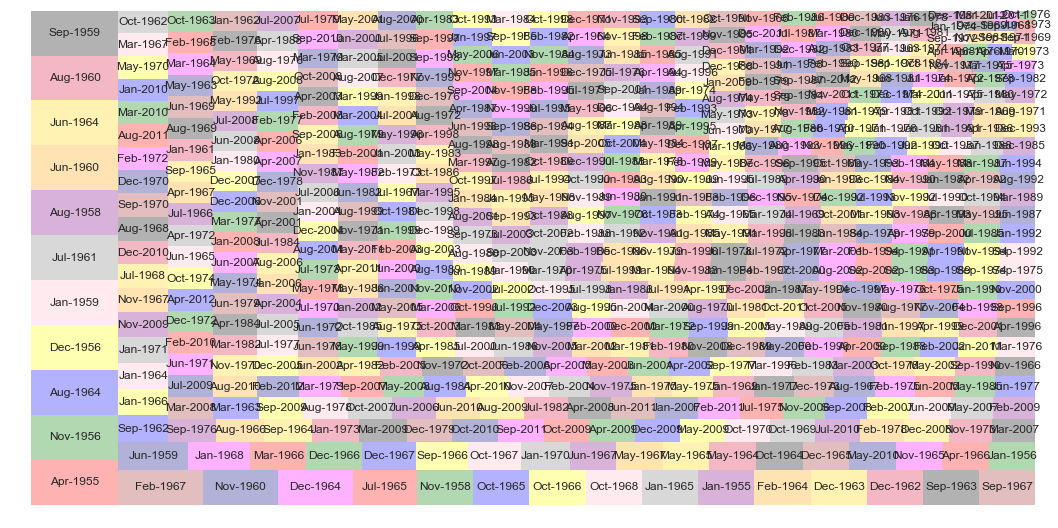

revol_util


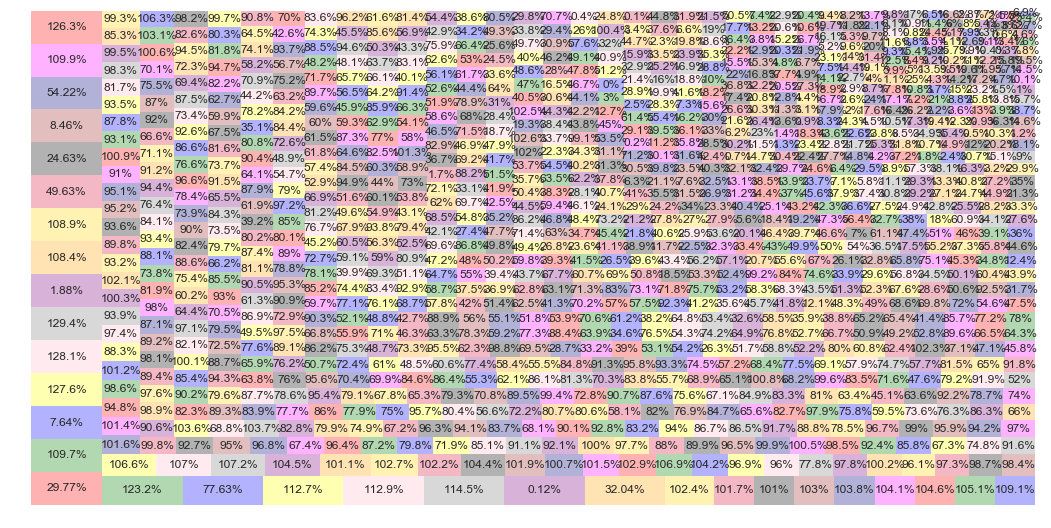

last_pymnt_d


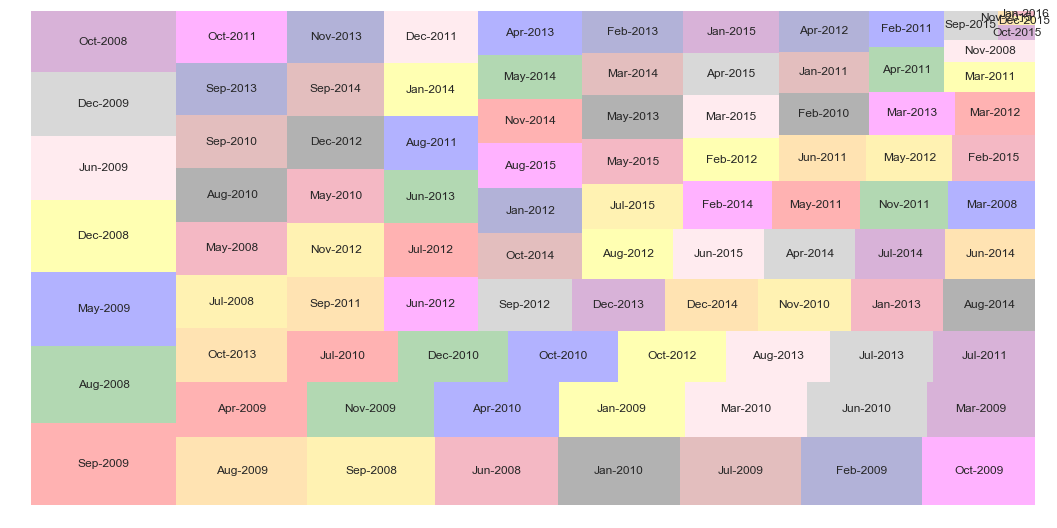

next_pymnt_d


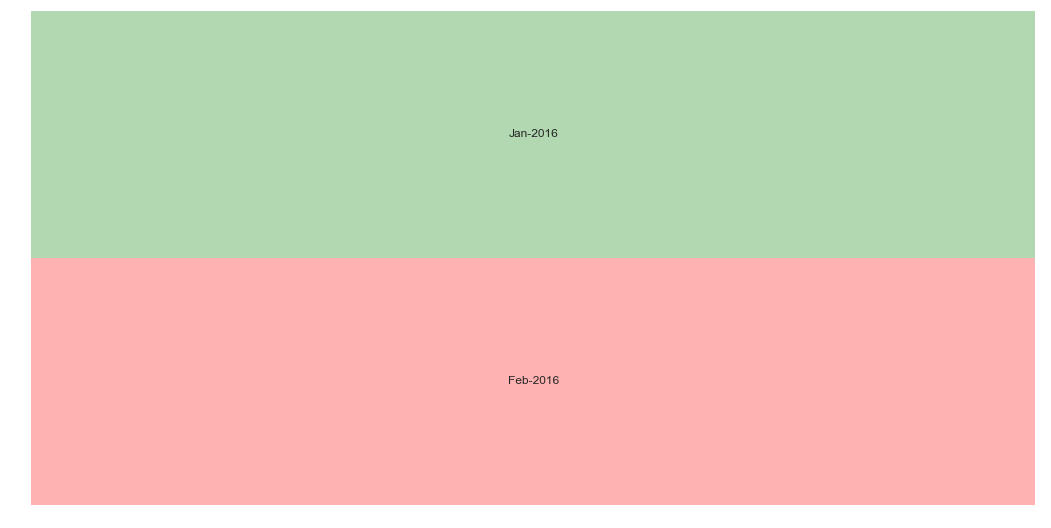

last_credit_pull_d


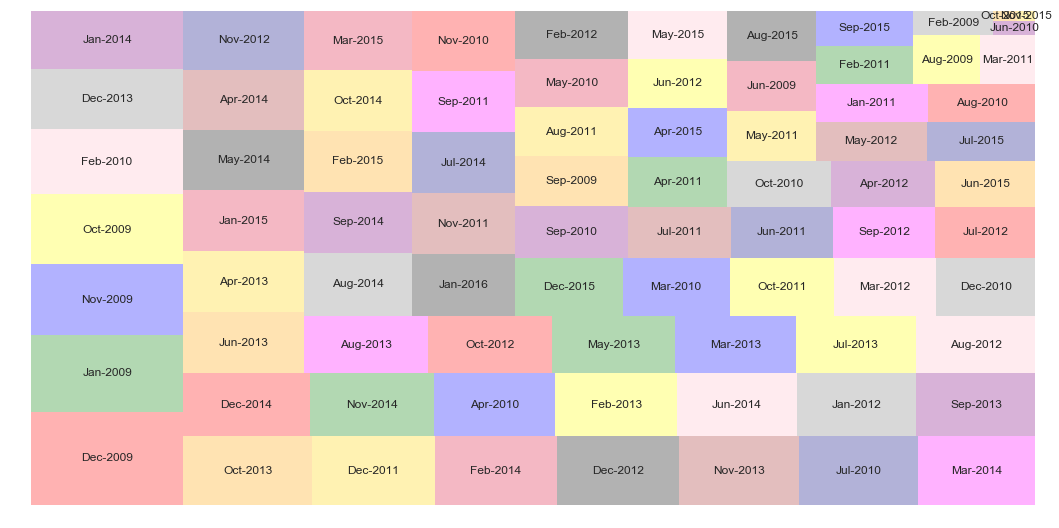

In [24]:
def treemap(var_list):
    for var in var_list:
        var_cal = data.groupby([var])['loan_status'].sum()/data.groupby([var]).size()

        var_label = []
        var_ratio = []

        for i in range(len(var_cal.index)):
            if var_cal.loc[var_cal.index[i]] != 0:
                var_label.append(var_cal.index[i])
                
            if var_cal.loc[var_cal.index[i]] != 0:
                var_ratio.append(var_cal.loc[var_cal.index[i]])
                
        columns = ['var_label','var_ratio']
        df_var = pd.DataFrame(columns=columns)
        df_var['var_label'] = var_label
        df_var['var_ratio'] = var_ratio
        df_var
        df_var = df_var.sort_values(by="var_ratio", ascending=False)

        labels = df_var['var_label']
        fig = plt.figure(figsize=(18, 20))
        ax = fig.add_subplot(211)

        squarify.plot(sizes=df_var['var_ratio']
                      , label=labels
                      , alpha=.3
                      , color=['red', 'green', 'blue', 'yellow', 'pink', 'grey', 'purple', 'orange', 'gold', 'crimson', 'black', 'brown', 'navy', 'fuchsia']
                      , ax=ax)
        plt.axis('off')
        print(var)
        plt.show()        
        
treemap(cat_var_list2)

# 3. Prepare variables for analysis

## 3.1 Drop some initials variables

In [ ]:
# should calculate correlations to see which ones are dependent on each other?

# exclVar = []

# data.drop(exclVar,axis=1,inplace = True)

In [10]:
# change interest rate to float

data['int_rate'] = data['int_rate'].replace('%','',regex=True).astype('float')/100

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 3.2 Remove features with high null proportion

In [11]:
null_pct = 100 * data.isnull().sum()/data.shape[0]
ds       = data[null_pct[null_pct <= 75].index]
print('The following features have been removed because of too many NULLs:\n{}' .\
    format(null_pct[null_pct > 75]))

The following features have been removed because of too many NULLs:
mths_since_last_record         87.484215
next_pymnt_d                   99.520439
mths_since_last_major_derog    81.165344
annual_inc_joint               99.999607
dti_joint                      99.999607
verification_status_joint      99.999607
open_acc_6m                    99.943350
open_il_6m                     99.943350
open_il_12m                    99.943350
open_il_24m                    99.943350
mths_since_rcnt_il             99.944923
total_bal_il                   99.943350
il_util                        99.950431
open_rv_12m                    99.943350
open_rv_24m                    99.943350
max_bal_bc                     99.943350
all_util                       99.943350
inq_fi                         99.943350
total_cu_tl                    99.943350
inq_last_12m                   99.943350
dtype: float64


## 3.3 Impute NULL-values

### 3.3.1 Fill-in with special values where median is not acceptable

In [12]:
# when to do this?

### 3.3.2 Impute NULL-values with median in case of the numerical variables

In [13]:
ds_num   = ds.select_dtypes(exclude = ['object'])
num_vars = ds_num.columns.values
print('Number of numeric features with NULL: {}'.\
      format(len(ds_num.columns[ds_num.isnull().any()].tolist())))
imptr    = preprocessing.Imputer(missing_values='NaN', strategy = 'median', axis = 0)
imptr    = imptr.fit(ds_num)
ds_num   = pd.DataFrame(data = imptr.transform(ds_num), columns = num_vars)
print('Number of NULLs after imputation: {}'.\
      format(len(ds_num.columns[ds_num.isnull().any()].tolist())))

Number of numeric features with NULL: 5
Number of NULLs after imputation: 0


## 3.4 Remove features with zero variance

In [14]:
data.shape

(254191, 75)

In [15]:
# Remove features with zero variance
var_thresh = VarianceThreshold().fit(ds_num)
zv_columns = ds_num.columns[var_thresh.variances_ <= var_thresh.threshold]
ds_num.drop(zv_columns, axis=1, errors='ignore', inplace=True)
print('Dropped the following features due to zero variance:\n{}' .\
     format(zv_columns.values))

Dropped the following features due to zero variance:
['policy_code']


In [16]:
# drop index values
num_features_to_drop = ['index', 'member_id']
ds_num.drop(num_features_to_drop, axis=1, errors='ignore', inplace=True)

## 3.5 Preprocessing of Categorical Features

In [17]:
ds_cat   = ds.select_dtypes(include = ['object'])
ds_cat.is_copy = False # avoid SettingWithCopy warning

print('Categorial features, dimensions before preprocessing: {}\n'.format(ds_cat.shape))

# Remove some categorial features upfront
useless_cat_features = ['index', 'id', 'emp_title', 'url', 'desc', 'title']
time_variables = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d']
cat_features_to_drop = useless_cat_features + time_variables
ds_cat.drop(cat_features_to_drop, axis=1, errors='ignore', inplace=True)
cat_vars = ds_cat.columns.values

    
# # Replace categories with few occurances
# for col in cat_vars:
#     num_cat = len(ds_cat[col].unique())
#     if num_cat > 15: # at most 10 categories
#         print('\n Column {0} has {1} categories, consolidating them ...'.format(col, num_cat))
#         occur = ds_cat[col].value_counts()
#         for x in occur[occur < ds_cat.shape[0]*.025].keys(): # Replace categories with less than 2.5% occurances
#             ds_cat.loc[ds_cat[col] == x, col] = 'Other_'+ col
#         print(' Number of categories after consolidation: {}'.\
#               format(len(ds_cat[col].unique())))
#         print('Consolidated category frequencies: \n{}'.format(ds_cat[col].value_counts()))

# Replace NULL values with 'Unknown'
ds_cat = ds_cat[(ds_cat.isnull().sum() > 0).index.values].fillna('Unknown')

# Convert objects into categoricals
for col in cat_vars:
    ds_cat[col] = ds_cat[col].astype('category')
    
print('Categorial features, dimensions after preprocessing: {} \n'.format(ds_cat.shape))

Categorial features, dimensions before preprocessing: (254191, 22)

Categorial features, dimensions after preprocessing: (254191, 14) 



In [18]:
# before dummy variables
ds_num.index = ds.index
ds_before_dummy = pd.concat([ds_num, ds_cat], axis = 1)

# Move target variable to front
target_var = data['loan_status']
ds_before_dummy.drop('loan_status', axis=1, errors='ignore', inplace=True)
ds_before_dummy.insert(0, 'default_flag', target_var)

In [18]:
# Perform a one-hot encoding of the categorial features
ds_one_hot = pd.get_dummies(ds_cat)
print('Generated {} one-hot dummy columns from categorial features'.format(ds_one_hot.shape[1]))

Generated 2867 one-hot dummy columns from categorial features


In [19]:
# Merge all features back into one data frame
ds_num.index = ds.index
ds = pd.concat([ds_num, ds_one_hot], axis = 1)

In [48]:
# Move target variable to front
target_var = data['loan_status']
ds.drop('loan_status', axis=1, errors='ignore', inplace=True)
ds.insert(0, 'default_flag', target_var)

## 3.6 Create Training And Testing sets

In [20]:
# Split the data set into training and test
X, y = ds.iloc[:, 1:], ds.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

In [ ]:
# validations?

# 4. Model

## 4.1 Random forest - 1st try

In [124]:
### Random Forest - base
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=1500, 
                                random_state=1,
                                n_jobs=10,
                                verbose=1)
rf = forest.fit(X_train,y_train)

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   34.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  7.4min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 13.2min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 20.7min
[Parallel(n_jobs=10)]: Done 1500 out of 1500 | elapsed: 25.2min finished


In [125]:
# Variable Importance
pd.DataFrame(rf.feature_importances_, 
             index=X_train.columns,columns=['Importance']).sort_values(['Importance'],ascending=False).head(30)

Importance
total_rec_prncp                     0.150385
last_pymnt_amnt                     0.128220
recoveries                          0.103627
collection_recovery_fee             0.093771
total_pymnt                         0.086641
total_pymnt_inv                     0.081773
funded_amnt_inv                     0.028781
loan_amnt                           0.027981
funded_amnt                         0.027564
installment                         0.027214
total_rec_int                       0.019417
int_rate                            0.012705
dti                                 0.007365
tot_cur_bal                         0.006759
total_rec_late_fee                  0.006689
annual_inc                          0.006602
total_rev_hi_lim                    0.006595
revol_bal                           0.006562
term_ 36 months                     0.006039
term_ 60 months                     0.006001
total_acc                           0.004673
grade_A                             0.004309
open_acc                            0.004235
out_prncp                           0.003936
out_prncp_inv                       0.003903
mths_since_last_delinq              0.003299
inq_last_6mths                      0.002450
verification_status_Not Verified    0.002057
initial_list_status_w               0.002035
initial_list_status_f               0.002018

In [127]:
accuracy_score(y_train, rf.predict(X_train))

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   31.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 1500 out of 1500 | elapsed:  2.3min finished


1.0

In [128]:
accuracy_score(y_test, rf.predict(X_test))

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   12.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   17.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   24.5s
[Parallel(n_jobs=10)]: Done 1500 out of 1500 | elapsed:   29.4s finished


0.99350887775708774

In [134]:
data[['total_rec_prncp', 'loan_amnt', 'last_pymnt_amnt', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'loan_status']]

total_rec_prncp  loan_amnt  last_pymnt_amnt  recoveries   total_pymnt  \
0               5000.00     5000.0           171.62        0.00   5861.071414   
1                456.46     2500.0           119.66      117.08   1008.710000   
2               2400.00     2400.0           649.91        0.00   3003.653644   
3              10000.00    10000.0           357.48        0.00  12226.302212   
5               5000.00     5000.0           161.03        0.00   5631.377753   
7               3000.00     3000.0           111.34        0.00   3938.144334   
8                162.02     5600.0           152.39      189.06    646.020000   
9                673.48     5375.0           121.45      269.29   1476.190000   
10              6500.00     6500.0          1655.54        0.00   7677.520000   
11             12000.00    12000.0          6315.30        0.00  13943.080000   
12              1256.14     9000.0           305.38      444.30   2270.700000   
13              3000.00     3000.0           102.43        0.00   3478.981915   
14              5433.47    10000.0           325.74      645.10   7471.990000   
15              1000.00     1000.0            36.32        0.00   1270.171106   
16             10000.00    10000.0           370.46        0.00  12519.260450   
17              3600.00     3600.0           583.45        0.00   3785.020000   
18              6000.00     6000.0            16.98        0.00   7164.499852   
19              9200.00     9200.0          8061.10        0.00   9459.960000   
20             20250.00    20250.0          6024.09        0.00  27663.042671   
21             10694.96    21000.0           701.73        0.00  14025.400000   
22             10000.00    10000.0           349.21        0.00  11902.561575   
23             10000.00    10000.0          4942.63        0.00  11536.310000   
24              1305.58     6000.0           198.46      269.31   2050.140000   
25             15000.00    15000.0          2447.05        0.00  15823.480000   
26                 0.00    15000.0             0.00        0.00      0.000000   
27               629.05     5000.0           123.65      260.96   1609.120000   
28              4000.00     4000.0          2638.77        0.00   4484.790000   
29              8500.00     8500.0           581.59        0.00  10122.208614   
30              4375.00     4375.0           144.94        0.00   4898.543558   
31             31825.00    31825.0         16966.70        0.00  34886.080000   
...                 ...        ...              ...         ...           ...   
887168         24000.00    24000.0         21779.88        0.00  24704.450000   
887181           854.44    24875.0           742.27        0.00   2897.690000   
887182         26500.00    26500.0         25220.50        0.00  29308.020000   
887189         24000.00    24000.0         23066.80        0.00  25941.710000   
887191         15000.00    15000.0         15103.25        0.00  15082.600000   
887193         20000.00    20000.0         20083.28        0.00  20049.970000   
887197           451.51    11200.0           296.67        0.00   1174.240000   
887198         20000.00    20000.0         18019.46        0.00  21420.510000   
887202         30000.00    30000.0           140.76        0.00  32488.990000   
887206         12000.00    12000.0          9178.83        0.00  13148.040000   
887219         12825.00    12825.0         12170.64        0.00  13520.670000   
887253         27650.00    27650.0         27645.25        0.00  29104.710000   
887258          1160.10     7200.0           249.56        0.00   1734.930000   
887267         25000.00    25000.0         22199.24        0.00  27775.420000   
887268         20000.00    20000.0         16534.04        0.00  21895.490000   
887272          3222.40    20000.0           100.00        0.00   4935.810000   
887279          1413.79    29675.0           685.27        0.00   2696.040000   
887283          5875.00     5875.0     

## 4.1 Random forest - 2nd try

In [22]:
ds2 = ds
ds2_drop_var = ['total_rec_prncp', 'last_pymnt_amnt', 'recoveries', 'total_pymnt', 'collection_recovery_fee', 'total_pymnt_inv']
ds2.drop(ds2_drop_var, axis=1, errors='ignore', inplace=True)

In [23]:
X2, y2 = ds2.iloc[:, 1:], ds2.iloc[:, 0].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)

In [24]:
forest2 = RandomForestClassifier(criterion='entropy',
                                n_estimators=700, 
                                random_state=1,
                                n_jobs=10,
                                verbose=1)
rf2 = forest2.fit(X_train2,y_train2)

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   60.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  5.9min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 13.9min
[Parallel(n_jobs=10)]: Done 700 out of 700 | elapsed: 22.4min finished


In [28]:
# Variable Importance
pd.DataFrame(rf2.feature_importances_, 
             index=X_train2.columns,columns=['Importance']).sort_values(['Importance'],ascending=False).head(30)

Importance
int_rate                               0.034965
total_rec_int                          0.033106
dti                                    0.030292
annual_inc                             0.029575
revol_bal                              0.026043
installment                            0.025664
tot_cur_bal                            0.024580
total_rev_hi_lim                       0.023373
funded_amnt_inv                        0.022889
total_acc                              0.022835
loan_amnt                              0.021748
funded_amnt                            0.021645
open_acc                               0.019977
mths_since_last_delinq                 0.016787
total_rec_late_fee                     0.016141
inq_last_6mths                         0.011448
term_ 36 months                        0.006711
grade_A                                0.006535
out_prncp_inv                          0.006435
term_ 60 months                        0.006313
out_prncp                              0.006283
tot_coll_amt                           0.005735
delinq_2yrs                            0.005726
purpose_debt_consolidation             0.005262
emp_length_10+ years                   0.005255
verification_status_Verified           0.004795
verification_status_Source Verified    0.004674
initial_list_status_w                  0.004613
initial_list_status_f                  0.004610
pub_rec                                0.004519

In [27]:
accuracy_score(y_train2, rf2.predict(X_train2))

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   17.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   42.3s
[Parallel(n_jobs=10)]: Done 700 out of 700 | elapsed:  6.8min finished


1.0

In [29]:
accuracy_score(y_test2, rf2.predict(X_test2))

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   19.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   48.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 700 out of 700 | elapsed:  1.2min finished


0.8277164363083217

## 4.3 Multi Layer Perceptron

In [60]:
# ds_NN = ds
# ds_NN_drop_var = ['total_rec_prncp', 'last_pymnt_amnt', 'recoveries', 'total_pymnt', 'collection_recovery_fee', 'total_pymnt_inv']
# ds_NN.drop(ds_NN_drop_var, axis=1, errors='ignore', inplace=True)

### 4.3.1 Handle outliers and perform min-max normalization

In [53]:
# take out outliers
print('Shape of the data  outlier filtering: {}'.format(ds_before_dummy.shape))
#keep only the ones that are within +3 to -3 standard deviations
ds_before_dummy[(np.abs(stats.zscore(ds_before_dummy)) < 3).all(axis=1)]
# ds_before_dummy[np.abs(ds_before_dummy-ds_before_dummy.mean())<=(3*ds_NN.std())]
print('Shape of the data after outlier filtering: {}'.format(ds_before_dummy.shape))

Shape of the data  outlier filtering: (254191, 44)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [19]:
# min-max normalization
# def normalize(df):
#     result = df.copy()
#     for feature_name in df.columns:
#         if np.issubdtype(df[feature_name].dtype, np.number):
#             max_value = df[feature_name].max()
#             min_value = df[feature_name].min()
#             result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#         else:
#             result[feature_name] = df[feature_name]
#     return result

def normalize(df):
    ds_copy = df.copy()
    for feature_name in ds_copy.columns:
        max_value = ds_copy[feature_name].max()
        min_value = ds_copy[feature_name].min()
        ds_copy[feature_name] = (ds_copy[feature_name] - min_value) / (max_value - min_value)
    return ds_copy

ds_normalized_num = normalize(ds_before_dummy.select_dtypes(exclude = ['category']))

In [20]:
# create dummy variables
ds_NN_num   = ds_normalized_num
ds_NN_cat   = ds_before_dummy.select_dtypes(include = ['category'])

# merge numeric and dummy variables
ds_NN_dummy = pd.get_dummies(ds_NN_cat)
ds_NN_num.index = ds_before_dummy.index
ds_NN = pd.concat([ds_NN_num, ds_NN_dummy], axis = 1)

ds_NN_drop_var = ['total_rec_prncp', 'last_pymnt_amnt', 'recoveries', 'total_pymnt', 'collection_recovery_fee', 'total_pymnt_inv']
ds_NN.drop(ds_NN_drop_var, axis=1, errors='ignore', inplace=True)

In [21]:
X_NN, y_NN = ds_NN.iloc[:, 1:], ds_NN.iloc[:, 0].values
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_NN, y_NN, test_size=0.3, random_state=0)

In [22]:
# Define a MLP
clf = MLPClassifier(activation='logistic', solver='adam',hidden_layer_sizes=(36,20,5),max_iter=200,shuffle=True,verbose=True)

# Train MLP
clf.fit(X_train_NN,y_train_NN)

Iteration 1, loss = 0.55494105
Iteration 2, loss = 0.47625781
Iteration 3, loss = 0.46312845
Iteration 4, loss = 0.43874097
Iteration 5, loss = 0.42833867
Iteration 6, loss = 0.42244174
Iteration 7, loss = 0.41838830
Iteration 8, loss = 0.41510073
Iteration 9, loss = 0.41258428
Iteration 10, loss = 0.40983344
Iteration 11, loss = 0.40782519
Iteration 12, loss = 0.40576537
Iteration 13, loss = 0.40402551
Iteration 14, loss = 0.40241262
Iteration 15, loss = 0.40085548
Iteration 16, loss = 0.39966439
Iteration 17, loss = 0.39843772
Iteration 18, loss = 0.39716407
Iteration 19, loss = 0.39618804
Iteration 20, loss = 0.39463911
Iteration 21, loss = 0.39355904
Iteration 22, loss = 0.39218985
Iteration 23, loss = 0.39108736
Iteration 24, loss = 0.38996097
Iteration 25, loss = 0.38837803
Iteration 26, loss = 0.38668174
Iteration 27, loss = 0.38512245
Iteration 28, loss = 0.38328929
Iteration 29, loss = 0.38147301
Iteration 30, loss = 0.37938215
Iteration 31, loss = 0.37732378
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(36, 20, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [24]:
# Base Test Results
print('DT0 AUC value on Train set: {}'.format(roc_auc_score(y_train_NN,clf.predict_proba(X_train_NN)[:,1])))
print('DT0 AUC value on Test set: {}'.format(roc_auc_score(y_test_NN,clf.predict_proba(X_test_NN)[:,1])))

DT0 AUC value on Train set: 0.9890987428548635
DT0 AUC value on Test set: 0.6485138640252995
